# Example 3

This is an example that reproduces Figure 5a-c from the main text. We load two sequences of models optimized on two independent data samples generated from the same ramping model. We then calculate feature complexity for these models and perform feature consistency analysis to select the optimal model. The analysis is performed for non-stationary data. Adopted for the latest neuralflow version.

In [1]:
import neuralflow
import numpy as np
import matplotlib.pyplot as plt, matplotlib.gridspec as gridspec
from neuralflow.utilities.visualization_functions import plot_spikes, plot_fitting_results
import warnings
from neuralflow.feature_complexity.fc_base import FC_tools
warnings.simplefilter(action='ignore', category=FutureWarning)

## Step 1: Load data and calculate Feature complexities (FC)

In this example, data will be loaded from `npz` files. To obtain this files, we generated 400 trials of data from the ramping dynamics with the following parameters: `'peq_model':{"model": "linear_pot", "params": {"slope": -5}}`, `'p0_model': {'model': 'single_well', 'params': {'miu': 200, 'xmin': -0.3}}`, `D0 : 0.1`. We then split our data into two independent halves, $D=D_1+D_2$, where $D_1$ contains the first 200, and $D_2$ contains the second 200 trials. We fit two models on each of the dataset by performing 10000 gradient-descent iterations. Here we only fit the potential function, and fix the rest of the parameters (performing 10000 iteration can take ~5-10 hours, thus in this example we offer you to load the optimization results).


Fitting results were saved in two data files (one for each optimization). Each data file contains the following entries: 

`iter_num`: array of integers, iteration numbers on which `peqs` were recorded, 

`peqs`: 2D array of fitted peqs (only recorded at iterations specified by `iter_num` array), 

`logliks`: negative training loglikelihoods recorded on each iteration, 

`logliksCV`: negative validated loglikelihoods recorded on each iteration (we don't use it in this example). 


1) Initialize a ground-truth model.

2) Load data files with the fitting results and convert them into dictionaries.

3) Initialize feature complexity class and calculate the ground-truth feature complexity

In [2]:
grid = neuralflow.GLLgrid(Np = 8, Ne = 16)
gt_model = neuralflow.model.new_model(
    peq_model ={"model": "linear_pot", "params": {"slope": -5}},
    p0_model = {'model': 'single_well', 'params': {'miu': 200, 'xmin': -0.3}},
    D = 0.1,
    fr_model = [{'model': 'linear','params': {'slope': 50, 'bias': 60}}],
    grid = grid
)
data1 = dict(np.load('data/Ex3_datasample1.npz',allow_pickle=True))
data2 = dict(np.load('data/Ex3_datasample2.npz',allow_pickle=True))

# This is needed to change the old format into the new format
data1['peq'] = [el[np.newaxis,:] for el in data1['peqs'].T]
data2['peq'] = [el[np.newaxis,:] for el in data2['peqs'].T]
del data1['peqs']
del data2['peqs']

fc = FC_tools(non_equilibrium = True, model = gt_model)
FC_gt, _, _ = fc.compute_FC()

## Step 2: Calculate JSD for each level of Feature complexity

Here we follow the algorithm described in Methods of Genkin, Hughes, Engel, Nat. Comm. 2021. For each model in `FCs_array1`, we consider $2*\rm{FC_{stride}}+1$ models in `FCs_array2` with similar feature complexities. We calculate JS divergences between the first model and all of the considered models from `FCs_array2`, and select a minimal value. We repeat this for each model in `FCs_array1`. We also save the indices of the optimal models for each level of feature complexity (min_inds1 and min_inds2 that allows us to find the pair of models in data1/data2 arrays for each level of the feature complexity).

In [3]:
JS_thres=0.0015
FC_stride = 5
smoothing_kernel = 0
num_models = 100 # Number of models for which Feature complexity will be calculated

FC1, min_inds1, FC2, min_inds2, JS, FC1_opt_ind = fc.FeatureConsistencyAnalysis(
    data1, data2, JS_thres, FC_stride, smoothing_kernel, num_models
    )

## Step 3. Visualize the results.
To visualise the results, we use FC1_opt_ind to find the optimal feature complexity where the JS divergence between the two models first exceeds the threshold. We will compare the selected models against the ground-truth model. To illustrate the process of model selection, we also plot a pair of models at early feature complexity (FC_early) and late feature complexity (FC_late). As expected, at small feature complexity both potentials tightly overlap, but undefitted and do not overlap with the ground-truth. At large feature complexity the potentials are overfitted and contain the features not presented in the ground-truth model.

Text(0, 0.5, 'Potential, $\\Phi(x)$')

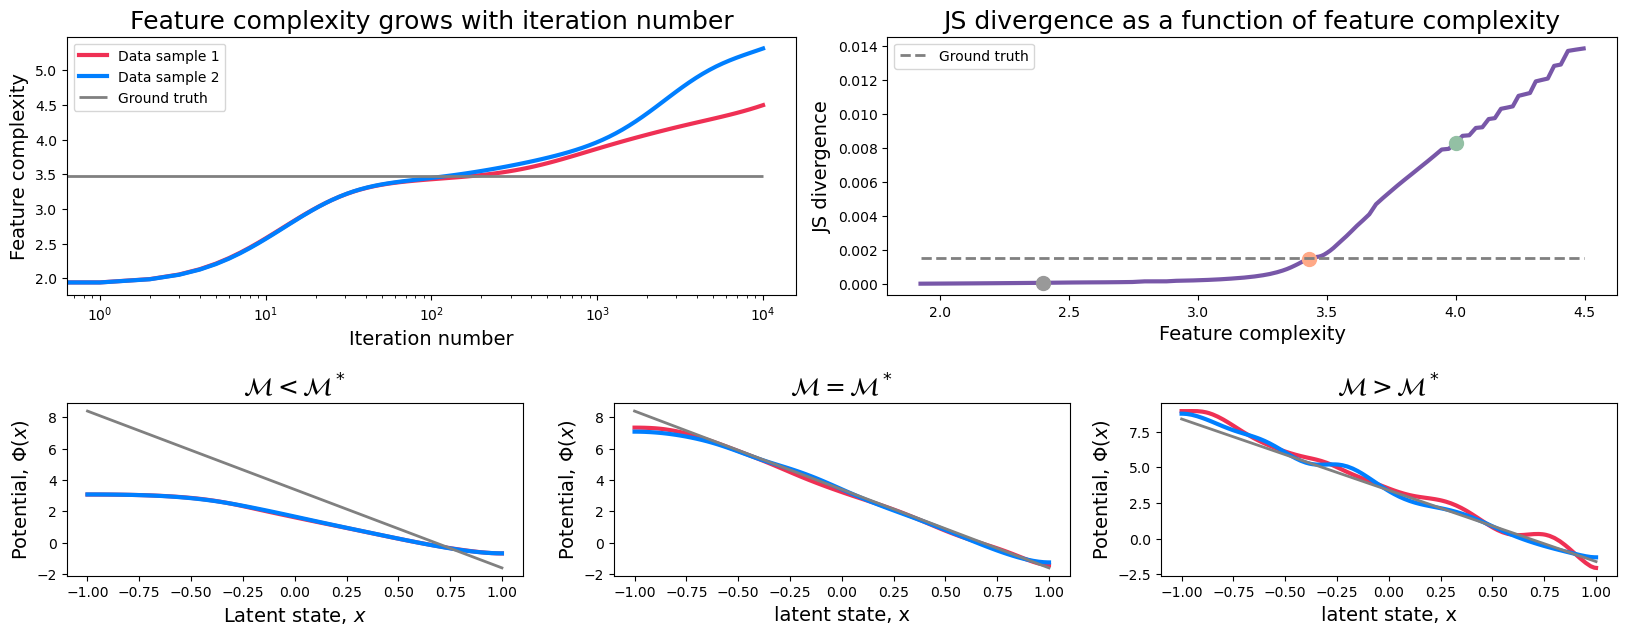

In [4]:
#%%capture
#Optimal FC
FC_opt = FC1[FC1_opt_ind]
#For illustration purposes, choose early and late FCs.
FC_late=4
late_ind = np.where(FC1 > FC_late)[0][0]
FC_early=2.4
early_ind = np.where(FC1 > FC_early)[0][0]

#Visualization
fig=plt.figure(figsize=(20,7));
gs=gridspec.GridSpec(2,6,height_ratios=[3,2],hspace=0.5, wspace=0.5);
line_colors = [[239/255, 48/255, 84/255], [0, 127/255, 1], [0.5, 0.5, 0.5]]
dot_colors = [[0.6,0.6,0.6], [1, 169/255, 135/255],  [147/255, 192/255, 164/255]]

ax = plt.subplot(gs[0,:3])
ax.set_title('Feature complexity grows with iteration number', fontsize=18)
ax.plot(data1['iter_num'][min_inds1], FC1, color=line_colors[0], linewidth=3, label='Data sample 1')
ax.plot(data2['iter_num'][min_inds1], FC2, color=line_colors[1], linewidth=3, label='Data sample 2')
ax.hlines(FC_gt, data1['iter_num'][min_inds1][0], data1['iter_num'][min_inds1][-1],color=line_colors[2],linewidth=2,label='Ground truth')
plt.xscale('log')
plt.xlabel('Iteration number', fontsize=14)
plt.ylabel('Feature complexity', fontsize=14)
plt.legend()

ax=plt.subplot(gs[0,3:])
ax.set_title('JS divergence as a function of feature complexity', fontsize=18)
ax.plot(FC1, JS, color = [0.47, 0.34, 0.66], linewidth=3)
ax.plot(FC_early, JS[np.argmin(np.abs(FC1-FC_early))],'.', markersize=20, color=dot_colors[0])
ax.plot(FC_opt, JS[np.argmin(np.abs(FC1-FC_opt))],'.', markersize=20, color=dot_colors[1])
ax.plot(FC_late, JS[np.argmin(np.abs(FC1-FC_late))],'.', markersize=20, color=dot_colors[2])
ax.hlines(JS_thres, FC1[0], FC1[-1], linestyles='dashed', color=line_colors[2], linewidth=2, label='Ground truth')
plt.xlabel('Feature complexity',fontsize=14)
plt.ylabel('JS divergence', fontsize=14)
plt.legend()

ax=plt.subplot(gs[1,:2])
ax.set_title(r'$\mathcal{M}<\mathcal{M}^*$', fontsize=18)
ax.plot(grid.x_d, -np.log(data1['peq'][int(min_inds1[early_ind])][0]), color=line_colors[0], linewidth=3)
ax.plot(grid.x_d, -np.log(data2['peq'][int(min_inds2[early_ind])][0]), color=line_colors[1], linewidth=3)
ax.plot(grid.x_d, -np.log(gt_model.peq[0]), color=[0.5, 0.5, 0.5], linewidth=2)
plt.xlabel(r'Latent state, $x$', fontsize=14)
plt.ylabel(r'Potential, $\Phi(x)$', fontsize=14)

ax=plt.subplot(gs[1,2:4])
ax.set_title(r'$\mathcal{M}=\mathcal{M}^*$', fontsize=18)
ax.plot(grid.x_d, -np.log(data1['peq'][int(min_inds1[FC1_opt_ind])][0]), color=line_colors[0], linewidth=3)
ax.plot(grid.x_d, -np.log(data2['peq'][int(min_inds2[FC1_opt_ind])][0]), color=line_colors[1], linewidth=3)
ax.plot(grid.x_d, -np.log(gt_model.peq[0]), color=[0.5, 0.5, 0.5], linewidth=2)
plt.xlabel('latent state, x', fontsize=14)
plt.ylabel(r'Potential, $\Phi(x)$', fontsize=14)

ax=plt.subplot(gs[1,4:])
ax.set_title(r'$\mathcal{M}>\mathcal{M}^*$', fontsize=18)
ax.plot(grid.x_d, -np.log(data1['peq'][int(min_inds1[late_ind])][0]), color=line_colors[0], linewidth=3)
ax.plot(grid.x_d, -np.log(data2['peq'][int(min_inds2[late_ind])][0]), color=line_colors[1], linewidth=3)
ax.plot(grid.x_d, -np.log(gt_model.peq[0]), color=[0.5, 0.5, 0.5], linewidth=2)
plt.xlabel('latent state, x', fontsize=14)
plt.ylabel(r'Potential, $\Phi(x)$', fontsize=14)

